In [150]:
%matplotlib inline

import os
import random
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet101


print(torch.__version__)
print(torchvision.__version__)

BATCH_SIZE = 16

2.0.1+cu118
0.15.2+cu118


In [137]:
# Вынесем отдельно необходиые функции
def plot_samples(dataset, num_samples=5):
    """Функция выводит на экран случайные экземпляры датасета"""
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))
    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()


def train_model(model, device, dataloaders, criterion, optimizer, batch_size, num_epochs=25):
    """Функция обучения модели, возвращает модель и списки метрик на каждой эпохе"""
    since = time.time()
    loss_train = []
    acc_train = []
    loss_valid = []
    acc_valid = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # На каждой эпохе происходит обучение и валидая 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            
            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проходим по данным
            for inputs, labels in dataloaders[phase]:
                batch += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем прогноз модели и считаем лосс
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)
                
                # посмотрим на статистики на каждых 10 батчах
                if batch%10 == 0 and phase == "train":
                  print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                  batch, current_loss/(batch_size*batch), 100*current_corrects/(batch_size*batch)))
            
            if phase == 'train':
                epoch_loss = current_loss / train_dataset.__len__()
                epoch_acc = current_corrects.double() / train_dataset.__len__()
                loss_train.append(epoch_loss)
                acc_train.append(epoch_acc.item())
            elif phase == 'val':
                epoch_loss = current_loss / valid_dataset.__len__()
                epoch_acc = current_corrects.double() / valid_dataset.__len__()
                loss_valid.append(epoch_loss)
                acc_valid.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model, loss_train, acc_train, loss_valid, acc_valid


def visualize_model(model, num_images=6):
    """Функция выводит на эран результаты предсказания обученной модели"""
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    if use_gpu:
        device = 'cuda'
    else:
        device = 'cpu'

    with torch.no_grad():
        for _ in range(num_images):
            example = random.choice(dataloaders['val'].dataset)
            inputs = example[0].unsqueeze(0)
            inputs = inputs.to(device)
            labels = torch.tensor(example[1]).unsqueeze(0)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

        model.train(mode=was_training)

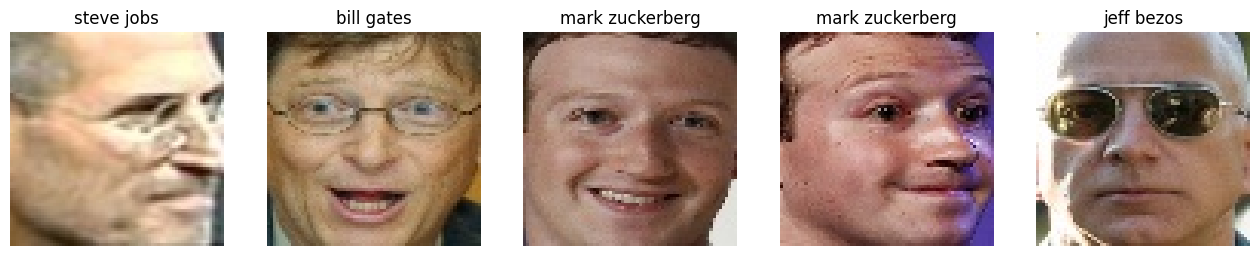

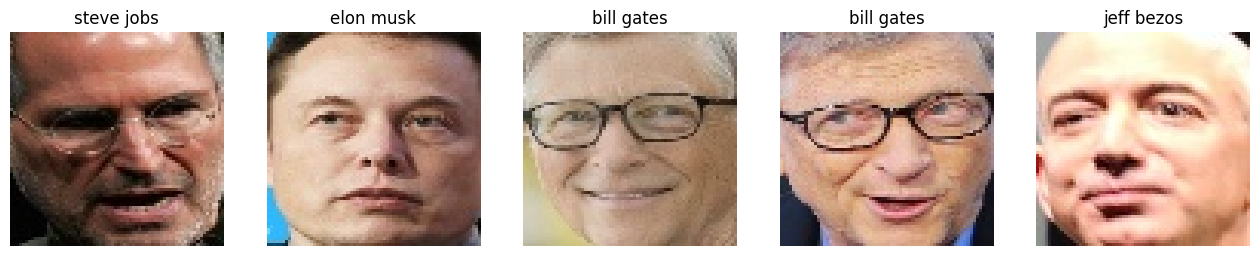

In [138]:
# Загрузим датасеты и посмторим примеры
train_dataset = ImageFolder("data/train/")
valid_dataset = ImageFolder("data/valid/")

plot_samples(train_dataset)
plot_samples(valid_dataset)

In [139]:
# Добавим нормализацию и аугментации к датасетам и создадим DataLoader
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset.transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
valid_dataset.transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.ToTensor(),
    normalize
])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()
)

In [140]:
# Сделаем словарь классов
classes = train_dataset.classes
classes

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

In [141]:
# Загрузим предобученноую модель
# Модель несколько устарела, однако она хорошо справляется
# с задачей классификации на ImageNet при не очень большом
# параметров. Сначал пробовал resnet34, однако за 30 
# эпох не смогла достич требуемой точности
model = resnet101(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [142]:
# Помним, что заморозка предполагает фиксацию весов модели во время обретного распространения ошибки 
for param in model.parameters():
    param.requires_grad = False

# Посмотрим, сколько нейронов подается на вход выходному полносвязному слою
n_neurons = model.fc.in_features 
print(n_neurons)

# Заменим этот слой на новый, выходное количество нейронов которого соотвествует нашей задачи классификации
num_classes = len(classes)
model.fc = nn.Linear(n_neurons, num_classes)

2048


In [143]:
# Укажем, что последний слой необходимо обучать
for _, param in enumerate(model.fc.parameters()):
    param.requires_grad = True

In [144]:
# Выберем устройство для обучения модели
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

# Укажем loss-функцию и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())

True


In [145]:
# Сделаем словать соответсвия фазы обучения и даталоадера
dataloaders = {'train': train_loader,
               'val': valid_loader}

In [146]:
# Обучим модель на 30 эпохах
res101, loss_train, acc_train, loss_valid, acc_valid = train_model(
    model, 
    device, 
    dataloaders, 
    criterion, 
    optimizer, 
    batch_size=BATCH_SIZE, 
    num_epochs=30
    )

Epoch 0/29
----------
Batch 10, Train Loss:1.6855, Train ACC:23.1250
Batch 20, Train Loss:1.5042, Train ACC:36.8750
Batch 30, Train Loss:1.3946, Train ACC:42.9167
Batch 40, Train Loss:1.2960, Train ACC:48.4375
Batch 50, Train Loss:1.2350, Train ACC:51.6250
Batch 60, Train Loss:1.1720, Train ACC:54.1667
Batch 70, Train Loss:1.1182, Train ACC:56.6964
Batch 80, Train Loss:1.0704, Train ACC:58.3594
Batch 90, Train Loss:1.0421, Train ACC:59.4444
Batch 100, Train Loss:1.0255, Train ACC:59.9375
Batch 110, Train Loss:1.0031, Train ACC:61.3636
Batch 120, Train Loss:0.9836, Train ACC:62.3438
Batch 130, Train Loss:0.9731, Train ACC:62.7404
Batch 140, Train Loss:0.9567, Train ACC:63.4375
Batch 150, Train Loss:0.9390, Train ACC:64.2083
Batch 160, Train Loss:0.9230, Train ACC:64.9219
Batch 170, Train Loss:0.9074, Train ACC:65.5882
Batch 180, Train Loss:0.8901, Train ACC:66.4583
train Loss: 0.8800 Acc: 0.6690
val Loss: 0.6137 Acc: 0.7746
Epoch 1/29
----------
Batch 10, Train Loss:0.5958, Train ACC:77

Как видим, модель достигла требуемой в задании точности. Визуализируем результаты.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


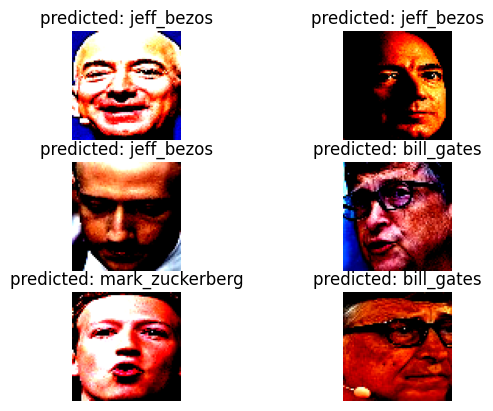

In [147]:
visualize_model(res101)
plt.show()

Модель отлично стправляется с тестовым датасетом. Посмотрим кривые обучения.

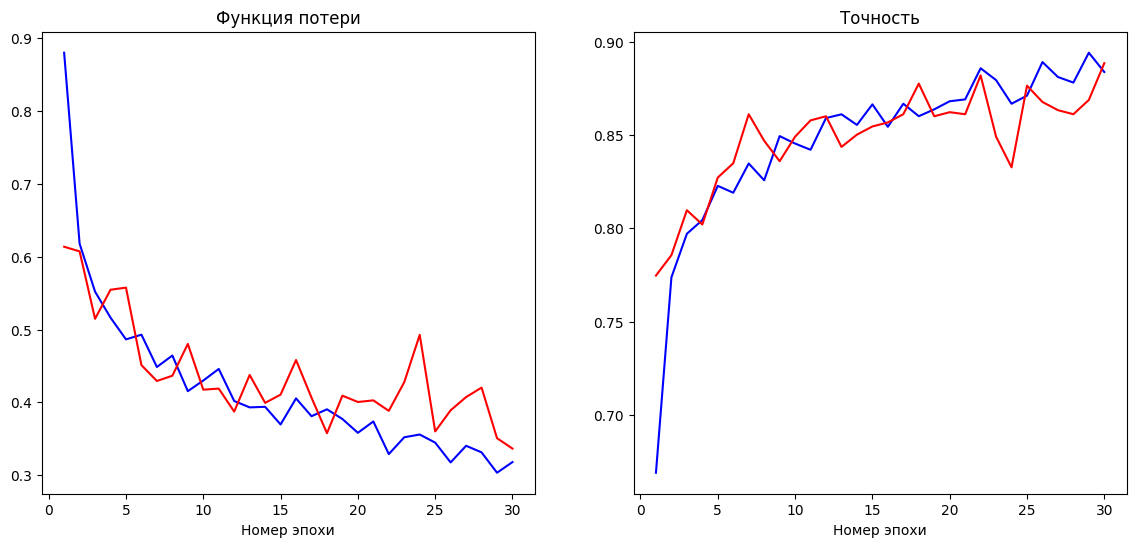

In [148]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Функция потери")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), acc_train, color="b")
plt.plot(range(1, len(loss_train) + 1), acc_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Точность")

plt.show()

В целом идет хорошая тенденция к снижению ошибки и увеличению точности. Так же, ошибка и точность на тренировчном и валидационном датасетах близки, значит переобучение не наблюдается. При продолжении обучения возможно достичь увеличения качества модели.